In [ ]:
!pip install opendatasets

In [ ]:
import opendatasets as od

od.download("https://www.kaggle.com/datasets/vaidehipawar/realtime-violence-dataset")

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: titus-tanashi
Your Kaggle Key: ··········
Dataset URL: https://www.kaggle.com/datasets/vaidehipawar/realtime-violence-dataset


100%|██████████| 1.02G/1.02G [00:34<00:00, 31.8MB/s]


In [ ]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


# **Importing the required libraries**

In [ ]:
import tensorflow as tf
import os
import shutil
import cv2
import math
import random
import numpy as np
import datetime as dt
import tensorflow
import keras
from collections import deque
import matplotlib.pyplot as plt

%matplotlib inline

from sklearn.model_selection import train_test_split

from keras.layers import *
from keras.models import Sequential
from tensorflow.keras.utils import to_categorical
from keras.callbacks import EarlyStopping
from tensorflow.keras.utils import plot_model

# **Visualize the Data**

In [ ]:
from IPython.display import HTML
from base64 import b64encode

# To Show a Video in Notebook
def Play_Video(filepath):
    html = ''
    video = open(filepath,'rb').read()
    src = 'data:video/mp4;base64,' + b64encode(video).decode()
    html += '<video width=640 muted controls autoplay loop><source src="%s" type="video/mp4"></video>' % src
    return HTML(html)

In [ ]:
# Classes Directories
NonViolenceVideos_Dir = "/content/drive/MyDrive/Project_năm_4/violence detect/video/non-violence/"
ViolenceVideos_Dir = "/content/drive/MyDrive/Project_năm_4/violence detect/video/violence/"

# Retrieve the list of all the video files present in the Class Directory.
NonViolence_files_names_list = os.listdir(NonViolenceVideos_Dir)
Violence_files_names_list = os.listdir(ViolenceVideos_Dir)

# Randomly select a video file from the Classes Directory.
Random_NonViolence_Video = random.choice(NonViolence_files_names_list)
Random_Violence_Video = random.choice(Violence_files_names_list)

**Play Random Non Violence Video**

In [ ]:
Play_Video(f"{NonViolenceVideos_Dir}/{Random_NonViolence_Video}")

**Play Random Violence Video**

In [ ]:
Play_Video(f"{ViolenceVideos_Dir}/{Random_Violence_Video}")

Output hidden; open in https://colab.research.google.com to view.

# **Extracting Frames**

In [ ]:
IMAGE_HEIGHT , IMAGE_WIDTH = 64, 64
SEQUENCE_LENGTH = 30

DATASET_DIR = "/content/drive/MyDrive/Project_năm_4/violence detect/video/"

CLASSES_LIST = ["non-violent","violent"]

In [ ]:
def frames_extraction(video_path):
    frames_list = []
    video_reader = cv2.VideoCapture(video_path)
    video_frames_count = int(video_reader.get(cv2.CAP_PROP_FRAME_COUNT))
    skip_frames_window = max(int(video_frames_count/SEQUENCE_LENGTH), 1)
    for frame_counter in range(SEQUENCE_LENGTH):
        video_reader.set(cv2.CAP_PROP_POS_FRAMES, frame_counter * skip_frames_window)
        success, frame = video_reader.read()
    if not success:
        break
    resized_frame = cv2.resize(frame, (IMAGE_HEIGHT, IMAGE_WIDTH))
    normalized_frame = resized_frame / 255
    frames_list.append(normalized_frame)
    video_reader.release()

    return frames_list

# **Creating the Data**

In [ ]:
def create_dataset():
    features = []
    labels = []
    video_files_paths = []
    for class_index, class_name in enumerate(CLASSES_LIST):
        print(f'Extracting Data of Class: {class_name}')
        files_list = os.listdir(os.path.join(DATASET_DIR, class_name))
        for file_name in files_list:
            video_file_path = os.path.join(DATASET_DIR, class_name, file_name)
            frames = frames_extraction(video_file_path)
            features.append(frames)
            labels.append(class_index)
            video_files_paths.append(video_file_path)

    return features, labels, video_files_paths

In [ ]:
features, labels, video_files_paths = create_dataset()

Extracting Data of Class: non-violence
Extracting Data of Class: violence


In [ ]:
np.save("features.npy",features)
np.save("labels.npy",labels)
np.save("video_files_paths.npy",video_files_paths)

In [ ]:
features, labels, video_files_paths = np.load("features.npy") , np.load("labels.npy") ,  np.load("video_files_paths.npy")

# **Encoding and Splitting Training-Testing Sets**

In [ ]:
# convert labels into one-hot-encoded vectors
one_hot_encoded_labels = to_categorical(labels)

In [ ]:
# Split the Data
features_train, features_test, labels_train, labels_test = train_test_split(features, one_hot_encoded_labels, test_size = 0.2,
                                                                            shuffle = True, random_state = 42)

In [ ]:
print(features_train.shape,labels_train.shape )
print(features_test.shape, labels_test.shape)

(184, 30, 64, 64, 3) (184, 2)
(46, 30, 64, 64, 3) (46, 2)


# **Importing Resnet and Fine-Tuning it.**

In [ ]:
from keras.applications import ResNet50

resnet = ResNet50(include_top=False , weights="imagenet", input_shape=(IMAGE_HEIGHT,IMAGE_WIDTH,3))

#Fine-Tuning to make the last 40 layer trainable
resnet.trainable = True

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


# **Building The Model**

In [ ]:
def create_model():

    model = Sequential()
    model.add(Input(shape = (SEQUENCE_LENGTH, IMAGE_HEIGHT, IMAGE_WIDTH, 3)))
    model.add(TimeDistributed(resnet))
    model.add(Dropout(0.25))
    model.add(TimeDistributed(Flatten()))

    lstm_fw = LSTM(units=32)
    lstm_bw = LSTM(units=32, go_backwards = True)
    model.add(Bidirectional(lstm_fw, backward_layer = lstm_bw))
    model.add(Dropout(0.25))

    model.add(Dense(256,activation='relu'))
    model.add(Dropout(0.25))

    model.add(Dense(128,activation='relu'))
    model.add(Dropout(0.25))

    model.add(Dense(64,activation='relu'))
    model.add(Dropout(0.25))

    model.add(Dense(32,activation='relu'))
    model.add(Dropout(0.25))

    model.add(Dense(2, activation = 'softmax'))
    model.summary()

    return model

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ time_distributed (TimeDistributed)   │ (None, 30, 2, 2, 2048)      │      23,587,712 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 30, 2, 2, 2048)      │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_1 (TimeDistributed) │ (None, 30, 8192)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional (Bidirectional)        │ (None, 64)                  │       2,105,600 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 256)                 │          16,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 2)                   │              66 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 25,753,250 (98.24 MB)

 Trainable params: 25,700,130 (98.04 MB)

 Non-trainable params: 53,120 (207.50 KB)

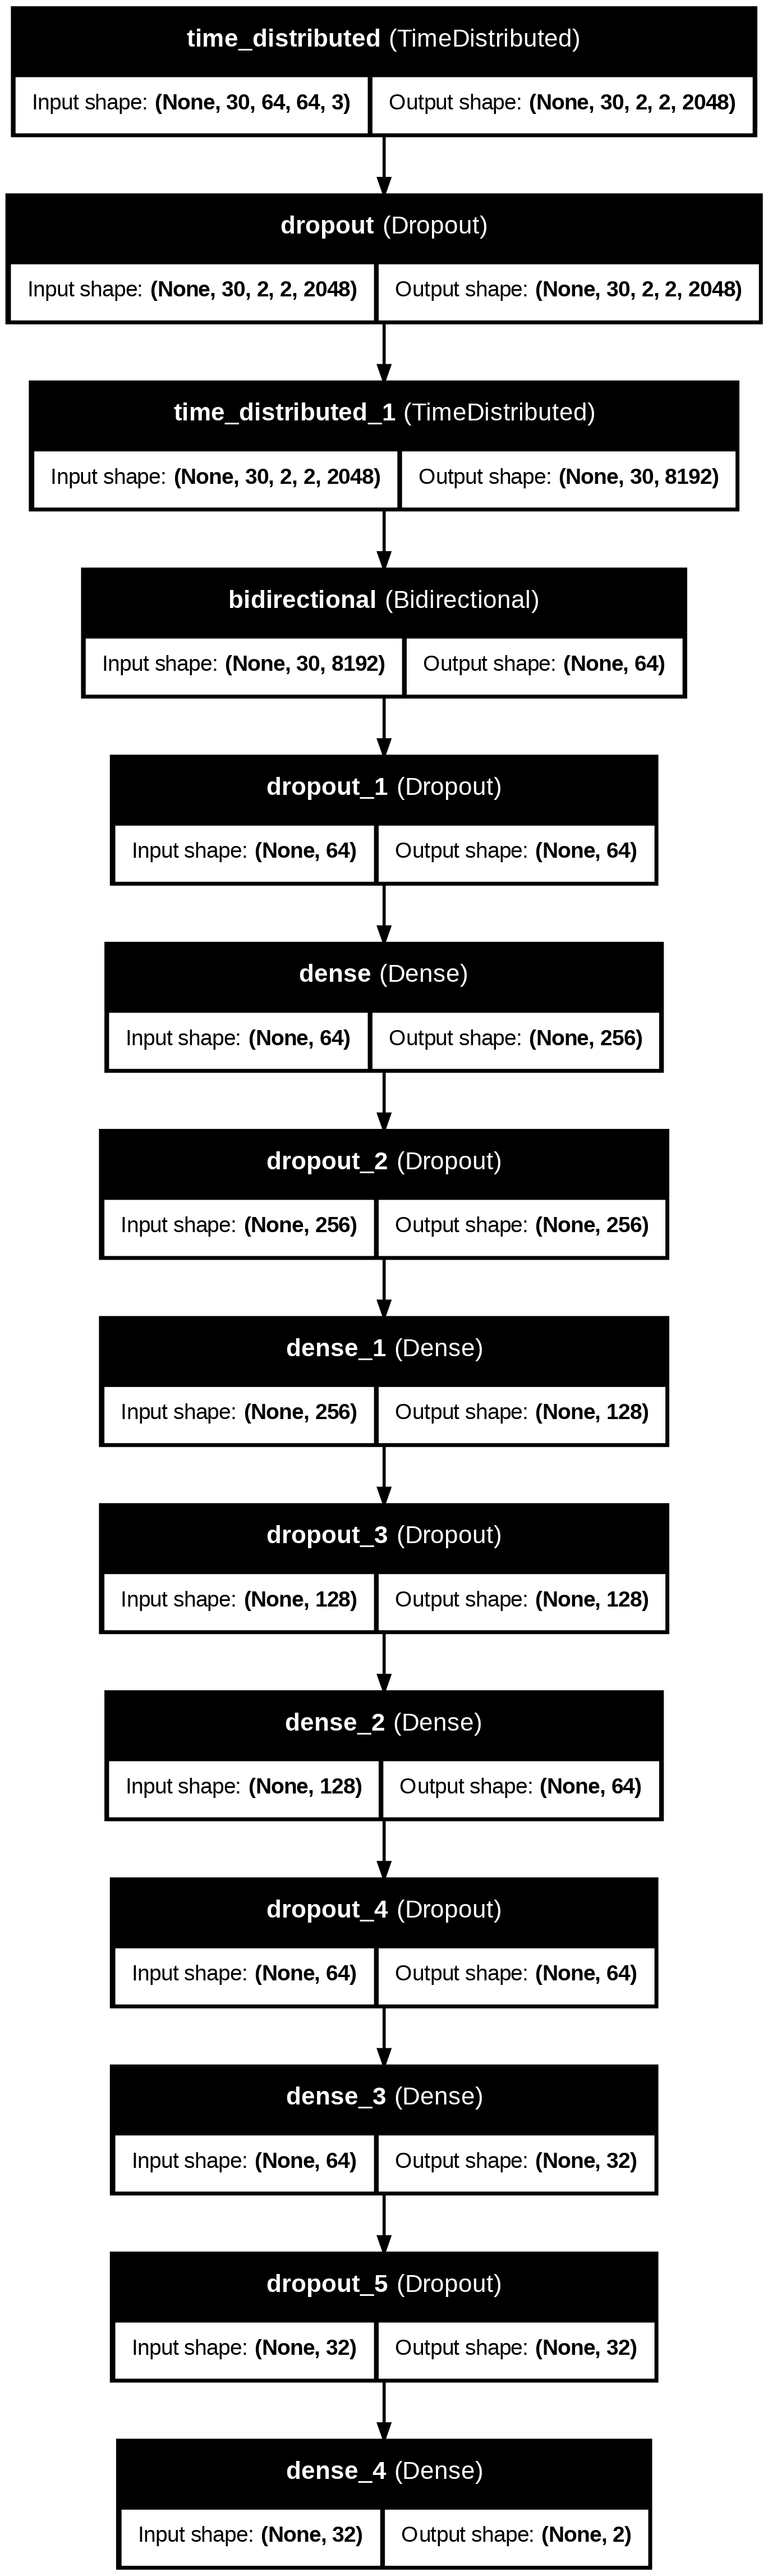

In [ ]:
resnetLSTM = create_model()
plot_model(resnetLSTM, to_file = 'resnetLSTM.png', show_shapes = True, show_layer_names = True)

# **Specifying Callbacks and Fitting**

In [ ]:
from tensorflow.keras.optimizers import Adam
early_stopping_callback = EarlyStopping(monitor = 'val_accuracy', patience = 10, restore_best_weights = True)

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss',
                                                  factor=0.3,
                                                  patience=5,
                                                  min_lr=0.000005,
                                                  verbose=1)

resnetLSTM.compile(loss = 'categorical_crossentropy', optimizer="sgd", metrics = ["accuracy"])

history = resnetLSTM.fit(x = features_train,
                         y = labels_train,
                         epochs = 50,
                         batch_size = 8,
                         shuffle = True,
                         validation_split = 0.2,
                         callbacks = [early_stopping_callback,reduce_lr])

Epoch 1/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 575s 5s/step - accuracy: 0.5108 - loss: 0.7052 - val_accuracy: 0.7027 - val_loss: 0.6791 - learning_rate: 0.0100
Epoch 2/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 64s 1s/step - accuracy: 0.4995 - loss: 0.6933 - val_accuracy: 0.5946 - val_loss: 0.6872 - learning_rate: 0.0100
Epoch 3/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 41s 1s/step - accuracy: 0.5464 - loss: 0.6821 - val_accuracy: 0.7027 - val_loss: 0.6661 - learning_rate: 0.0100
Epoch 4/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 25s 1s/step - accuracy: 0.6470 - loss: 0.6716 - val_accuracy: 0.7027 - val_loss: 0.6536 - learning_rate: 0.0100
Epoch 5/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 24s 1s/step - accuracy: 0.6694 - loss: 0.6598 - val_accuracy: 0.7027 - val_loss: 0.6014 - learning_rate: 0.0100
Epoch 6/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 42s 1s/step - accuracy: 0.7614 - loss: 0.5832 - val_accuracy: 0.7568 - val_loss: 0.5599 - learning_rate: 0.0100
Epoch 7/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 40s 1s/step - accuracy: 0.7590 - loss: 0.5688 - val_accuracy:

In [ ]:
resnetLSTM.save("violence_detect.h5")

In [ ]:
model_evaluation_history = resnetLSTM.evaluate(features_test, labels_test)

2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 740ms/step - accuracy: 0.8859 - loss: 0.2560


# **Model Evaluation**

In [ ]:
def plot_metric(model_training_history, metric_name_1, metric_name_2, plot_name):

    metric_value_1 = model_training_history.history[metric_name_1]
    metric_value_2 = model_training_history.history[metric_name_2]

    # Get the Epochs Count
    epochs = range(len(metric_value_1))

    plt.plot(epochs, metric_value_1, 'blue', label = metric_name_1)
    plt.plot(epochs, metric_value_2, 'orange', label = metric_name_2)

    plt.title(str(plot_name))

    plt.legend()

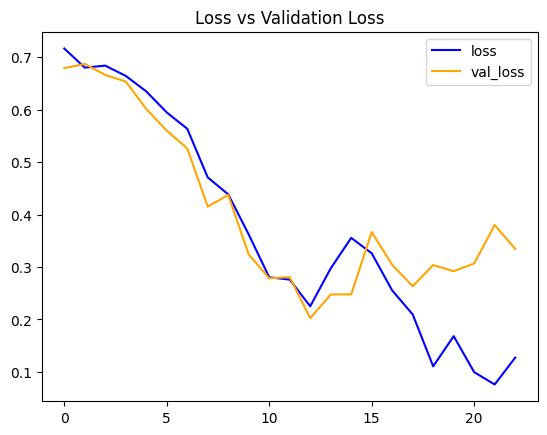

In [ ]:
plot_metric(history, 'loss', 'val_loss', 'Loss vs Validation Loss')

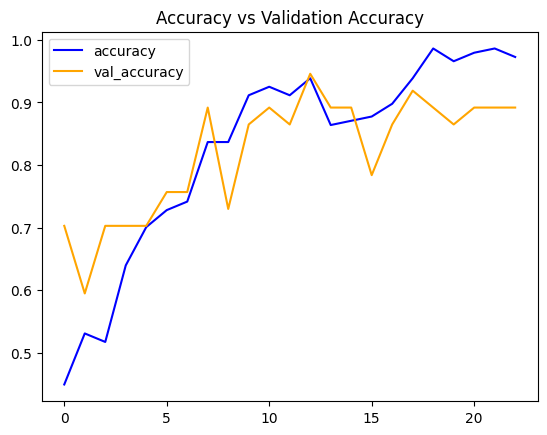

In [ ]:
plot_metric(history, 'accuracy', 'val_accuracy', 'Accuracy vs Validation Accuracy')

# **Predicting the Test Set**

In [ ]:
labels_predict = resnetLSTM.predict(features_test)

2/2 ━━━━━━━━━━━━━━━━━━━━ 125s 64s/step


In [ ]:
# Decoding the data to use in Metrics
labels_predict = np.argmax(labels_predict , axis=1)
labels_test_normal = np.argmax(labels_test , axis=1)

In [ ]:
labels_test_normal.shape , labels_predict.shape

((46,), (46,))

Accuracy Score

In [ ]:
from sklearn.metrics import accuracy_score
AccScore = accuracy_score(labels_predict, labels_test_normal)
print('Accuracy Score is : ', AccScore)

Accuracy Score is :  0.8695652173913043


Confusion Matrix

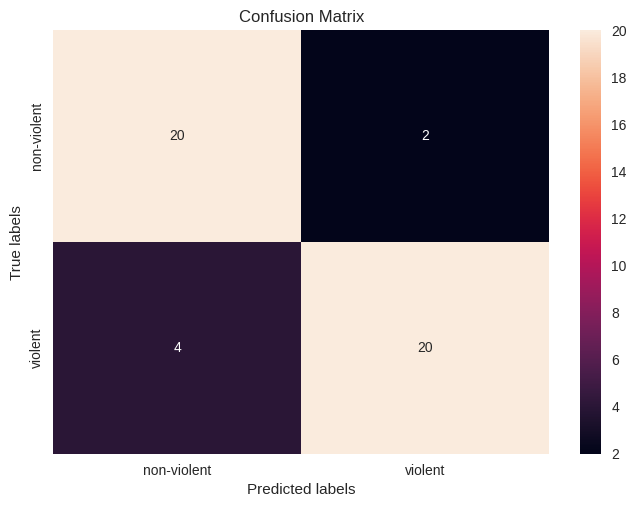

In [ ]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

ax= plt.subplot()
cm=confusion_matrix(labels_test_normal, labels_predict)
sns.heatmap(cm, annot=True, fmt='g', ax=ax);

ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels');
ax.set_title('Confusion Matrix');
ax.xaxis.set_ticklabels(['non-violent', 'violent']); ax.yaxis.set_ticklabels(['non-violent', 'violent']);

Classification Report

In [ ]:
from sklearn.metrics import classification_report

ClassificationReport = classification_report(labels_test_normal,labels_predict)
print('Classification Report is : \n', ClassificationReport)

Classification Report is : 
               precision    recall  f1-score   support

           0       0.83      0.91      0.87        22
           1       0.91      0.83      0.87        24

    accuracy                           0.87        46
   macro avg       0.87      0.87      0.87        46
weighted avg       0.87      0.87      0.87        46



# **Prediction Frame By Frame**

In [ ]:
def predict_frames(video_file_path, output_file_path, SEQUENCE_LENGTH):

    video_reader = cv2.VideoCapture(video_file_path)

    original_video_width = int(video_reader.get(cv2.CAP_PROP_FRAME_WIDTH))
    original_video_height = int(video_reader.get(cv2.CAP_PROP_FRAME_HEIGHT))

    video_writer = cv2.VideoWriter(output_file_path, cv2.VideoWriter_fourcc('m', 'p', '4', 'v'),
                                    video_reader.get(cv2.CAP_PROP_FPS), (original_video_width, original_video_height))

    frames_queue = deque(maxlen = SEQUENCE_LENGTH)
    predicted_class_name = ''
    while video_reader.isOpened():

        ok, frame = video_reader.read()

        if not ok:
            break
        resized_frame = cv2.resize(frame, (IMAGE_HEIGHT, IMAGE_WIDTH))

        normalized_frame = resized_frame / 255
        frames_queue.append(normalized_frame)
        if len(frames_queue) == SEQUENCE_LENGTH:
            predicted_labels_probabilities = resnetLSTM.predict(np.expand_dims(frames_queue, axis = 0))[0]
            predicted_label = np.argmax(predicted_labels_probabilities)
            predicted_class_name = CLASSES_LIST[predicted_label]
        if predicted_class_name == "non-violent":
            cv2.putText(frame, predicted_class_name, (5, 100), cv2.FONT_HERSHEY_SIMPLEX, 3, (0, 255, 0), 12)
        else:
            cv2.putText(frame, predicted_class_name, (5, 100), cv2.FONT_HERSHEY_SIMPLEX, 3, (0, 0, 255), 12)

        video_writer.write(frame)

    video_reader.release()
    video_writer.release()

In [ ]:
plt.style.use("default")

# To show Random Frames from the saved output predicted video (output predicted video doesn't show on the notebook but can be downloaded)
def show_pred_frames(pred_video_path):

    plt.figure(figsize=(20,15))

    video_reader = cv2.VideoCapture(pred_video_path)

    # Get the number of frames in the video.
    frames_count = int(video_reader.get(cv2.CAP_PROP_FRAME_COUNT))

    # Get Random Frames from the video then Sort it
    random_range = sorted(random.sample(range (SEQUENCE_LENGTH , frames_count ), 10))

    for counter, random_index in enumerate(random_range, 1):

        plt.subplot(5, 4, counter)

        # Set the current frame position of the video.
        video_reader.set(cv2.CAP_PROP_POS_FRAMES, random_index)

        ok, frame = video_reader.read()

        if not ok:
          break

        frame = cv2.cvtColor(frame , cv2.COLOR_BGR2RGB)

        plt.imshow(frame);ax.figure.set_size_inches(20,20);plt.tight_layout()

    video_reader.release()

In [ ]:
# Construct the output video path.
test_videos_directory = 'test_videos'
os.makedirs(test_videos_directory, exist_ok = True)

output_video_file_path = f'{test_videos_directory}/Output-Test-Video.mp4'

1/1 ━━━━━━━━━━━━━━━━━━━━ 59s 59s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 247ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 217ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 214ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 227ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 219ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 596ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0

NameError: name 'ax' is not defined

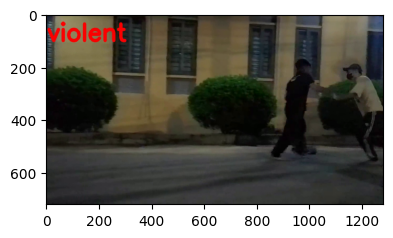

In [ ]:
input_video_file_path = "video_test.mp4"
predict_frames(input_video_file_path, output_video_file_path, SEQUENCE_LENGTH)

show_pred_frames(output_video_file_path)

In [ ]:
# Play the actual video
Play_Video(input_video_file_path)

# **Prediction For The Video**

In [ ]:
def predict_video(video_file_path, SEQUENCE_LENGTH):

    video_reader = cv2.VideoCapture(video_file_path)

    # Get the width and height of the video.
    original_video_width = int(video_reader.get(cv2.CAP_PROP_FRAME_WIDTH))
    original_video_height = int(video_reader.get(cv2.CAP_PROP_FRAME_HEIGHT))

    # Declare a list to store video frames we will extract.
    frames_list = []

    # Store the predicted class in the video.
    predicted_class_name = ''

    # Get the number of frames in the video.
    video_frames_count = int(video_reader.get(cv2.CAP_PROP_FRAME_COUNT))

    # Calculate the interval after which frames will be added to the list.
    skip_frames_window = max(int(video_frames_count/SEQUENCE_LENGTH),1)

    # Iterating the number of times equal to the fixed length of sequence.
    for frame_counter in range(SEQUENCE_LENGTH):

        # Set the current frame position of the video.
        video_reader.set(cv2.CAP_PROP_POS_FRAMES, frame_counter * skip_frames_window)

        success, frame = video_reader.read()

        if not success:
            break

        # Resize the Frame to fixed Dimensions.
        resized_frame = cv2.resize(frame, (IMAGE_HEIGHT, IMAGE_WIDTH))

        # Normalize the resized frame.
        normalized_frame = resized_frame / 255

        # Appending the pre-processed frame into the frames list
        frames_list.append(normalized_frame)

    # Passing the  pre-processed frames to the model and get the predicted probabilities.
    predicted_labels_probabilities = MoBiLSTM_model.predict(np.expand_dims(frames_list, axis = 0))[0]

    # Get the index of class with highest probability.
    predicted_label = np.argmax(predicted_labels_probabilities)

    # Get the class name using the retrieved index.
    predicted_class_name = CLASSES_LIST[predicted_label]

    # Display the predicted class along with the prediction confidence.
    print(f'Predicted: {predicted_class_name}\nConfidence: {predicted_labels_probabilities[predicted_label]}')

    video_reader.release()